# Phishing-Website-Detection

This repository contains code for predicting phishing websites in a webpage phishing dataset using various machine learning models. We explored three different models: Random Forest, XGBoost, and Support Vector Machine (SVM).

#### Methodology:
1. Data Cleaning and Preprocessing
2. Model Development
3. Model Saving

#### Dataset Used:
The dataset used for this project contains webpage phishing detection obtained from Kaggle

#### Usage:
To replicate the experiments or apply the trained model:
1. Obtain a similar dataset.
2. Follow the provided Jupyter notebooks or Python scripts for data preprocessing, model training.
3. Adjust parameters or algorithms as needed based on the specifics of your dataset.
4. Save the trained model using the provided code snippet with `pickle`.
5. Utilize the saved model for making predictions on new data.

#### Dependencies:
- Python 3
- Libraries: NumPy, pandas, scikit-learn, scipy, pickle


# Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import sklearn.metrics as metrics
from scipy.stats import randint, uniform
import pickle
from xgboost import XGBClassifier

# Load Dataset

In [2]:
df = pd.read_csv('kaggle/input/dataset_phishing.csv')

# Data Cleaning and Preprocessing

In [3]:
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

In [5]:
df.columns

Index(['url', 'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens',
       'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore',
       'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma',
       'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com',
       'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url',
       'ratio_digits_host', 'punycode', 'port', 'tld_in_path',
       'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains',
       'prefix_suffix', 'random_domain', 'shortening_service',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       'statistical_report', 

In [6]:
df['status'].value_counts()

legitimate    5715
phishing      5715
Name: status, dtype: int64

In [7]:
#change status into int dtype with legitimate as 0 and phishing as 1
mapping = {'legitimate':0, 'phishing':1}

df['status'] = df['status'].map(mapping)

In [8]:
df['status'].value_counts()

0    5715
1    5715
Name: status, dtype: int64

In [9]:
df = df.drop('url', axis=1)
corr_matrix = df.corr()

In [10]:
target_corr = corr_matrix['status']
target_corr

length_url         0.248580
length_hostname    0.238322
ip                 0.321698
nb_dots            0.207029
nb_hyphens        -0.100107
                     ...   
web_traffic        0.060388
dns_record         0.122119
google_index       0.731171
page_rank         -0.511137
status             1.000000
Name: status, Length: 88, dtype: float64

In [11]:
#only choose features with abs value > 0.1

threshold=0.1
relevant_features = target_corr[abs(target_corr)>threshold].index.tolist()
relevant_features

['length_url',
 'length_hostname',
 'ip',
 'nb_dots',
 'nb_hyphens',
 'nb_at',
 'nb_qm',
 'nb_and',
 'nb_eq',
 'nb_slash',
 'nb_semicolumn',
 'nb_www',
 'nb_com',
 'https_token',
 'ratio_digits_url',
 'ratio_digits_host',
 'tld_in_subdomain',
 'abnormal_subdomain',
 'nb_subdomains',
 'prefix_suffix',
 'shortening_service',
 'length_words_raw',
 'shortest_word_host',
 'longest_words_raw',
 'longest_word_host',
 'longest_word_path',
 'avg_words_raw',
 'avg_word_host',
 'avg_word_path',
 'phish_hints',
 'suspecious_tld',
 'statistical_report',
 'nb_hyperlinks',
 'ratio_intHyperlinks',
 'ratio_extRedirection',
 'external_favicon',
 'links_in_tags',
 'ratio_intMedia',
 'ratio_extMedia',
 'safe_anchor',
 'empty_title',
 'domain_in_title',
 'domain_with_copyright',
 'domain_registration_length',
 'domain_age',
 'dns_record',
 'google_index',
 'page_rank',
 'status']

In [12]:
#only select relevant features

X = df[relevant_features]
X = X.drop('status', axis=1)
X = X.drop('tld_in_subdomain', axis=1)
X = X.drop('ratio_intHyperlinks', axis=1)
X = X.drop('ratio_extRedirection', axis=1)
X = X.drop('external_favicon', axis=1)
X = X.drop(X.loc[:,'ratio_intMedia':'empty_title'].columns, axis=1)
X = X.drop(X.loc[:,'domain_with_copyright':'domain_registration_length'].columns, axis=1)
X = X.drop('page_rank', axis=1)
y = df['status']

In [13]:
pd.set_option('display.max_columns', None)
X.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_eq,nb_slash,nb_semicolumn,nb_www,nb_com,https_token,ratio_digits_url,ratio_digits_host,abnormal_subdomain,nb_subdomains,prefix_suffix,shortening_service,length_words_raw,shortest_word_host,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,suspecious_tld,statistical_report,nb_hyperlinks,links_in_tags,domain_in_title,domain_age,dns_record,google_index
0,37,19,0,3,0,0,0,0,0,3,0,1,0,1,0.000000,0.0,0,3,0,0,4,3,11,11,6,5.750000,7.0,4.500000,0,0,0,17,80.000000,0,-1,1,1
1,77,23,1,1,0,0,0,0,0,5,0,0,0,1,0.220779,0.0,0,1,0,0,4,19,32,19,32,15.750000,19.0,14.666667,0,0,0,30,100.000000,1,5767,0,1
2,126,50,1,4,1,0,1,2,3,5,0,0,1,0,0.150794,0.0,0,3,1,0,12,3,17,13,17,8.250000,8.4,8.142857,0,0,0,4,100.000000,1,4004,0,1
3,18,11,0,2,0,0,0,0,0,2,0,0,0,1,0.000000,0.0,0,2,0,0,1,5,5,5,0,5.000000,5.0,0.000000,0,0,0,149,100.000000,1,-1,0,0
4,55,15,0,2,2,0,0,0,0,5,0,1,0,1,0.000000,0.0,0,2,0,0,6,3,11,7,11,6.333333,5.0,7.000000,0,0,0,102,76.470588,0,8175,0,0


In [14]:
y.head()

0    0
1    1
2    1
3    0
4    0
Name: status, dtype: int64

# Model Development

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [16]:
scaler = StandardScaler()

In [17]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Random Forest

In [18]:
rf = RandomForestClassifier()
rf.fit(X_train_scaled,y_train)

RandomForestClassifier()

In [19]:
rf_predict = rf.predict(X_test_scaled)

In [20]:
accuracy = accuracy_score(y_test,rf_predict)
print("Accuracy:{}%".format(round(accuracy *100), 1))

Accuracy:96%


In [21]:
rf_Accuracy_Score = accuracy_score(y_test,rf_predict)
rf_JaccardIndex = jaccard_score(y_test,rf_predict)
rf_F1_Score = f1_score(y_test,rf_predict)
rf_Log_Loss = log_loss(y_test,rf_predict)

In [22]:
print(f"Accuracy: {rf_Accuracy_Score}")
print(f"Jaccard Index: {rf_JaccardIndex}")
print(f"F1 Score: {rf_F1_Score}")
print(f"Log Loss: {rf_Log_Loss}")

Accuracy: 0.9553805774278216
Jaccard Index: 0.9140690817186183
F1 Score: 0.9551056338028168
Log Loss: 1.5411205463393889


In [23]:
rf_conf_matrix = confusion_matrix(y_test,rf_predict)
rf_conf_matrix

array([[1099,   58],
       [  44, 1085]], dtype=int64)

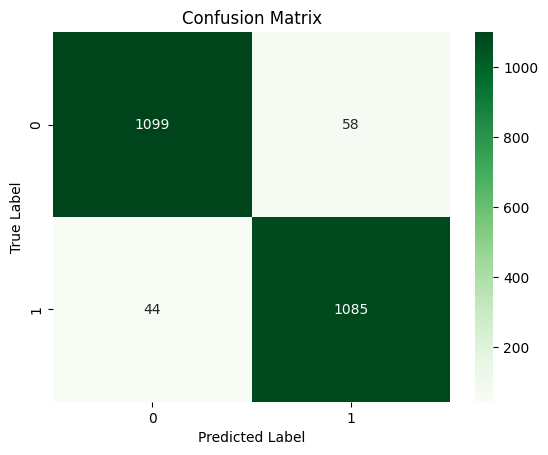

In [24]:
sns.heatmap(rf_conf_matrix,annot=True, fmt = 'd',cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [25]:
rf_report = classification_report(y_test,rf_predict)
print(rf_report)

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1157
           1       0.95      0.96      0.96      1129

    accuracy                           0.96      2286
   macro avg       0.96      0.96      0.96      2286
weighted avg       0.96      0.96      0.96      2286



## SVM

In [26]:
svm = SVC()
svm.fit(X_train_scaled,y_train)

SVC()

In [27]:
svm_predict = svm.predict(X_test_scaled)

In [28]:
accuracy = accuracy_score(y_test,svm_predict)
print("Accuracy:{}%".format(round(accuracy *100), 1))

Accuracy:95%


In [29]:
svm_Accuracy_Score = accuracy_score(y_test,svm_predict)
svm_JaccardIndex = jaccard_score(y_test,svm_predict)
svm_F1_Score = f1_score(y_test,svm_predict)
svm_Log_Loss = log_loss(y_test,svm_predict)

In [30]:
print(f"Accuracy: {svm_Accuracy_Score}")
print(f"Jaccard Index: {svm_JaccardIndex}")
print(f"F1 Score: {svm_F1_Score}")
print(f"Log Loss: {svm_Log_Loss}")

Accuracy: 0.9488188976377953
Jaccard Index: 0.9018456375838926
F1 Score: 0.9483899426554918
Log Loss: 1.767754686282876


In [31]:
svm_conf_matrix = confusion_matrix(y_test,svm_predict)
svm_conf_matrix

array([[1094,   63],
       [  54, 1075]], dtype=int64)

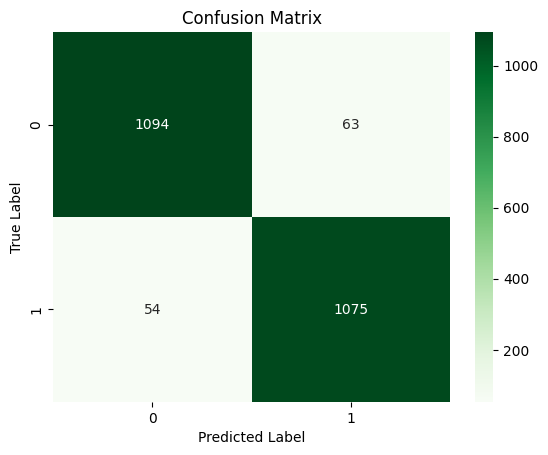

In [32]:
sns.heatmap(svm_conf_matrix,annot=True, fmt = 'd',cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## XGBoost

In [33]:
params = {
    'n_estimators': 100,
    'max_depth': 6,       
    'learning_rate': 0.1,
    'subsample': 0.8,     
    'colsample_bytree': 0.8, 
    'min_child_weight': 1,    
    'gamma': 0,                
    'objective': 'binary:logistic'
}

In [34]:
xgb = XGBClassifier(**params)
xgb.fit(X_train_scaled,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [35]:
xgb_predict = xgb.predict(X_test_scaled)

In [36]:
accuracy = accuracy_score(y_test,xgb_predict)
print("Accuracy:{}%".format(round(accuracy *100), 1))

Accuracy:96%


In [37]:
xgb_Accuracy_Score = accuracy_score(y_test,xgb_predict)
xgb_JaccardIndex = jaccard_score(y_test,xgb_predict)
xgb_F1_Score = f1_score(y_test,xgb_predict)
xgb_Log_Loss = log_loss(y_test,xgb_predict)

In [38]:
print(f"Accuracy: {xgb_Accuracy_Score}")
print(f"Jaccard Index: {xgb_JaccardIndex}")
print(f"F1 Score: {xgb_F1_Score}")
print(f"Log Loss: {xgb_Log_Loss}")

Accuracy: 0.9571303587051618
Jaccard Index: 0.9174389216512215
F1 Score: 0.9569420035149385
Log Loss: 1.4806852420613297


In [39]:
xgb_conf_matrix = confusion_matrix(y_test,xgb_predict)
xgb_conf_matrix

array([[1099,   58],
       [  40, 1089]], dtype=int64)

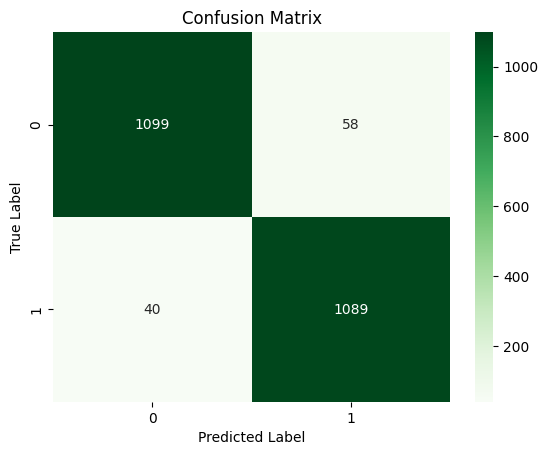

In [40]:
sns.heatmap(xgb_conf_matrix,annot=True, fmt = 'd',cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Model Accurancy

In [41]:
accuracy_scores = {
    'Random Forest' : round(accuracy_score(y_test,rf_predict), 2),
    'SVM' : round(accuracy_score(y_test,svm_predict), 2),
    'XGBoost' : round(accuracy_score(y_test,xgb_predict), 2)
}

In [42]:
accuracy_df = pd.DataFrame(list(accuracy_scores.items()), columns=['Model', 'Accuracy Score'])
accuracy_df

,Model,Accuracy Score
0,Random Forest,0.96
1,SVM,0.95
2,XGBoost,0.96


## Saving the Model

In [43]:
#saving the best performing model

filename = 'phishing_detection_model_xgb1.pkl'
pickle.dump(xgb, open(filename, 'wb'))

In [44]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test_scaled,y_test)
print(result)

0.9571303587051618


In [47]:
predict_good = [[18,11,0,2,0,0,0,0,0,2,0,0,0.0,0.0,0,2,0,1,5,5,5,0,5,5,0,0,0,0,149,100,1,-1,0,0]]
result = loaded_model.predict(predict_good)
print(result)

[1]
